In [1]:
%matplotlib inline
import tensorflow as tf

import numpy as np
# Explicit random seed for reproducibility
np.random.seed(7)  
import os
import matplotlib.pyplot as plt

tf.__version__

'1.4.0'

In [2]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.utils import np_utils

Using TensorFlow backend.


In [3]:
def normalize(data, coefficients):
    data = np.array(data, dtype=np.float32)
    for index, c in enumerate(coefficients): 
        data[:,index] /= c
    return data

In [4]:
def load_training_data(filename="data.csv", delimiter=";", skiprows=1, class1='NORMAL', class2='TRISOMY 21', force=False, normalization=True, 
                      column_mask=[False, False, False, False, False, True, True, True, True, True, False, True, True, True]):
    filepath = os.path.join('data', filename)
    npy_filepath_x = os.path.join('data', filename + '_x.npy')
    npy_filepath_y = os.path.join('data', filename + '_y.npy')
    npy_filepath_coefficients = os.path.join('data', filename + '_coefficients.npy')
    npy_filepath_ids = os.path.join('data', filename + '_id.npy')
    x = []
    y = []
    coefficients = [1]*8
    ids = []
    if force or not os.path.isfile(npy_filepath_x) or not os.path.isfile(npy_filepath_y) \
    or not os.path.isfile(npy_filepath_coefficients) or not os.path.isfile(npy_filepath_ids):
        raw_data = np.loadtxt(filepath, delimiter=delimiter, skiprows=skiprows, dtype=str)
        for line in raw_data:
            app = [n for n in line]
            app = np.array(app)
            m = np.array(column_mask)
            app = [float(n) for n in app[m]]
            x.append(np.asarray(app))
            y.append(0 if line[1] == class1 else 1)
            ids.append(line[0])
        x = np.array(x)
        y = np.array(y)
        ids = np.array(ids)
        if normalization:
            coefficients = x.max(axis=0)
            x = x / x.max(axis=0)
        np.save(npy_filepath_x, x)
        np.save(npy_filepath_y, y)
        np.save(npy_filepath_coefficients, coefficients)
        np.save(npy_filepath_ids, ids)
    else:
        x = np.load(npy_filepath_x)
        y = np.load(npy_filepath_y)
        coefficients = np.load(npy_filepath_coefficients)
        ids = np.load(npy_filepath_ids)

    return coefficients, x, y, ids

In [5]:
def load_blind_data(coefficients, filename="blind_samples.csv", delimiter=";", skiprows=1, force=False, normalization=True, 
                      column_mask=[False, True, True, True, True, True, True, True, True]):
    filepath = os.path.join('data', filename)
    npy_filepath_x = os.path.join('data', filename + '_x.npy')
    npy_filepath_ids = os.path.join('data', filename + '_id.npy')
    x = []
    ids = []
    if force or not os.path.isfile(npy_filepath_x) or not os.path.isfile(npy_filepath_ids):
        raw_data = np.loadtxt(filepath, delimiter=delimiter, skiprows=skiprows, dtype=str)
        for line in raw_data:
            app = [n for n in line]
            app = np.array(app)
            m = np.array(column_mask)
            app = [float(n) for n in app[m]]
            x.append(np.asarray(app))
            ids.append(line[0])
        x = np.array(x)
        ids = np.array(ids)
        if normalization:
            x = normalize(x, coefficients)
        np.save(npy_filepath_x, x)
        np.save(npy_filepath_ids, ids)
    else:
        x = np.load(npy_filepath_x)
        ids = np.load(npy_filepath_ids)
    return x, ids

In [6]:
(coefficients, x, y, ids) = load_training_data(force=True);

In [7]:
batch_size = 512
nb_classes = 2
nb_epoch = 150
# dense layer size
dense_layer_size1 = 100
# checkpoint path
checkpoints_filepath = "checkpoints/checkpoints.hdf5"
class_names = ['NORMAL', 'TRISOMY 21']

training_set_size_percentage = 100 # set to 70 or 80 during tuning

In [8]:
if training_set_size_percentage == 100:
    X_train = x
    X_test = x
    Y_train = y
    Y_test = y
else: 
    size = y.size
    training_size = int((size/100)*training_set_size_percentage)

    X_train = x[0:training_size]
    X_test = x[training_size:size]

    Y_train = y[0:training_size]
    Y_test = y[training_size:size]
    
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(Y_train, nb_classes)
Y_test = np_utils.to_categorical(Y_test, nb_classes)

X_train shape: (40, 8)
40 train samples
40 test samples


In [9]:
def initialize_network_single_column(model, nb_classes, dense_layer_size1):
    model.add(Dense(dense_layer_size1, name='fully_connected_1_' + str(dense_layer_size1) + '_neurons', 
                    input_shape=(8, )))
    model.add(Activation('relu', name='activation_1_' + 'relu'))
    model.add(Dropout(0.25))
    model.add(Dense(nb_classes, name='output_' + str(nb_classes) + '_neurons'))
    model.add(Activation('softmax', name='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adadelta',
                  metrics=['acc'])
        
model = Sequential()
initialize_network_single_column(model, nb_classes, dense_layer_size1)

In [10]:
# fits the model on clear training set, for nb_epoch-700 epochs
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch,
                    verbose=1, validation_data=(X_test, Y_test))

Train on 40 samples, validate on 40 samples
Epoch 1/150
40/40 [==============================] - 1s 26ms/step - loss: 0.7142 - acc: 0.6000 - val_loss: 0.7154 - val_acc: 0.5750
Epoch 2/150
40/40 [==============================] - 0s 200us/step - loss: 0.7213 - acc: 0.5750 - val_loss: 0.7129 - val_acc: 0.5500
Epoch 3/150
40/40 [==============================] - 0s 213us/step - loss: 0.7206 - acc: 0.4750 - val_loss: 0.7104 - val_acc: 0.5250
Epoch 4/150
40/40 [==============================] - 0s 200us/step - loss: 0.6970 - acc: 0.6000 - val_loss: 0.7081 - val_acc: 0.5250
Epoch 5/150
40/40 [==============================] - 0s 200us/step - loss: 0.7188 - acc: 0.5000 - val_loss: 0.7057 - val_acc: 0.5250
Epoch 6/150
40/40 [==============================] - 0s 187us/step - loss: 0.7074 - acc: 0.4750 - val_loss: 0.7034 - val_acc: 0.5000
Epoch 7/150
40/40 [==============================] - 0s 188us/step - loss: 0.7024 - acc: 0.7000 - val_loss: 0.7011 - val_acc: 0.5000
Epoch 8/150
40/40 [=======

Epoch 62/150
40/40 [==============================] - 0s 175us/step - loss: 0.6015 - acc: 0.7500 - val_loss: 0.6091 - val_acc: 0.7250
Epoch 63/150
40/40 [==============================] - 0s 163us/step - loss: 0.6208 - acc: 0.6500 - val_loss: 0.6075 - val_acc: 0.7250
Epoch 64/150
40/40 [==============================] - 0s 212us/step - loss: 0.6133 - acc: 0.7000 - val_loss: 0.6057 - val_acc: 0.7250
Epoch 65/150
40/40 [==============================] - 0s 225us/step - loss: 0.6073 - acc: 0.8000 - val_loss: 0.6040 - val_acc: 0.7250
Epoch 66/150
40/40 [==============================] - 0s 175us/step - loss: 0.5946 - acc: 0.7500 - val_loss: 0.6022 - val_acc: 0.7250
Epoch 67/150
40/40 [==============================] - 0s 200us/step - loss: 0.6046 - acc: 0.8000 - val_loss: 0.6003 - val_acc: 0.7250
Epoch 68/150
40/40 [==============================] - 0s 162us/step - loss: 0.6006 - acc: 0.7750 - val_loss: 0.5984 - val_acc: 0.7250
Epoch 69/150
40/40 [==============================] - 0s 163us

Epoch 123/150
40/40 [==============================] - 0s 200us/step - loss: 0.4541 - acc: 0.9500 - val_loss: 0.4562 - val_acc: 1.0000
Epoch 124/150
40/40 [==============================] - 0s 175us/step - loss: 0.4707 - acc: 0.9750 - val_loss: 0.4524 - val_acc: 1.0000
Epoch 125/150
40/40 [==============================] - 0s 162us/step - loss: 0.4691 - acc: 0.9500 - val_loss: 0.4489 - val_acc: 1.0000
Epoch 126/150
40/40 [==============================] - 0s 175us/step - loss: 0.4536 - acc: 1.0000 - val_loss: 0.4454 - val_acc: 1.0000
Epoch 127/150
40/40 [==============================] - 0s 150us/step - loss: 0.4434 - acc: 1.0000 - val_loss: 0.4416 - val_acc: 1.0000
Epoch 128/150
40/40 [==============================] - 0s 175us/step - loss: 0.4422 - acc: 1.0000 - val_loss: 0.4385 - val_acc: 1.0000
Epoch 129/150
40/40 [==============================] - 0s 162us/step - loss: 0.4504 - acc: 0.9250 - val_loss: 0.4350 - val_acc: 1.0000
Epoch 130/150
40/40 [==============================] - 

In [11]:
print('evaluating new model')
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

evaluating new model
Test score: 0.353582644463
Test accuracy: 1.0


In [12]:
def plot_history(history, metric='acc', loc='lower right'): 
    # list all data in history
    # print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric])
    if metric == 'acc': 
        metric = 'accuracy'
    plt.title('model ' + metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc=loc)
    plt.show()

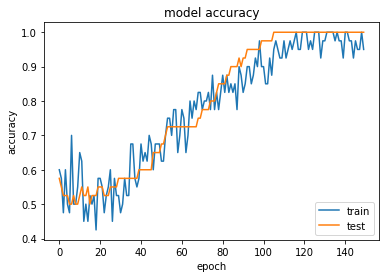

In [13]:
plot_history(history)

In [14]:
def predictions(data, probability=True):
    pred = np.array(model.predict_classes(data), dtype=np.int32)
    confidence = []
    if probability:
        confidence = model.predict(data)
    pred_class = [class_names[n] for n in pred]
    return pred_class, confidence

In [15]:
(blind_data, blind_data_ids) = load_blind_data(coefficients, force=True)
pred_class, confidence = predictions(blind_data)

In [16]:
def output_prediction_csv(blind_data_ids, pred_class, confidence):
    string = "id; predicted class; confidence\n"
    for index, val in enumerate(pred_class):
        string += blind_data_ids[index] + ";" + pred_class[index] + ";" + str(max(confidence[index])*100) + "%\n"
    return string

In [17]:
print(output_prediction_csv(blind_data_ids, pred_class, confidence))

id; predicted class; confidence
P41;NORMAL;65.7623231411%
P42;NORMAL;59.0517222881%
P43;NORMAL;73.5103130341%
P44;NORMAL;68.3148980141%
P45;NORMAL;65.2839303017%
P46;NORMAL;69.2266464233%
P47;NORMAL;71.4043140411%
P48;NORMAL;70.7800269127%
P49;NORMAL;77.3246943951%
P50;NORMAL;70.1256453991%
P51;NORMAL;74.5649337769%
P52;NORMAL;73.2305467129%
P53;NORMAL;63.942617178%
P54;NORMAL;68.7407195568%
P55;NORMAL;63.559371233%
P56;NORMAL;60.1560115814%
P57;NORMAL;63.1248891354%
P58;NORMAL;73.0675816536%
P59;NORMAL;63.0572259426%
P60;NORMAL;73.0524122715%
P61;NORMAL;61.8290066719%
P62;NORMAL;69.9579119682%
P63;NORMAL;70.202678442%
P64;NORMAL;66.0168588161%
P65;NORMAL;51.8779635429%
P66;NORMAL;65.4132246971%
P67;TRISOMY 21;80.0403058529%
P68;TRISOMY 21;60.4067027569%
P69;TRISOMY 21;99.9999880791%
P70;TRISOMY 21;99.8254597187%
P71;TRISOMY 21;81.2159359455%
P72;TRISOMY 21;89.3629848957%
P73;TRISOMY 21;89.4285559654%
P74;TRISOMY 21;89.0476167202%
P75;TRISOMY 21;99.9242424965%
P76;TRISOMY 21;91.7467713